# 1. Introduction

In this guide, we will preprocess data, wrangle it, perform descriptive, diagnotics and predictive analysis.

# 2. Data pre-processing

This is essential for cleaning and preparing data for analysis


**a. Data exploration**

In [ ]:
import pandas as pd

# Load the dataset
path = "/content/climate_dataset.csv"

df = pd.read_csv(path, low_memory=False)

In [ ]:
df.head()

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive
2,2006-08-29 01:52:30+00:00,23160,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive
3,2006-11-07 02:46:52+00:00,57868,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive


In [ ]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15789411 entries, 0 to 15789410
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   created_at       object 
 1   id               int64  
 2   lng              float64
 3   lat              float64
 4   topic            object 
 5   sentiment        float64
 6   stance           object 
 7   gender           object 
 8   temperature_avg  float64
 9   aggressiveness   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.2+ GB


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

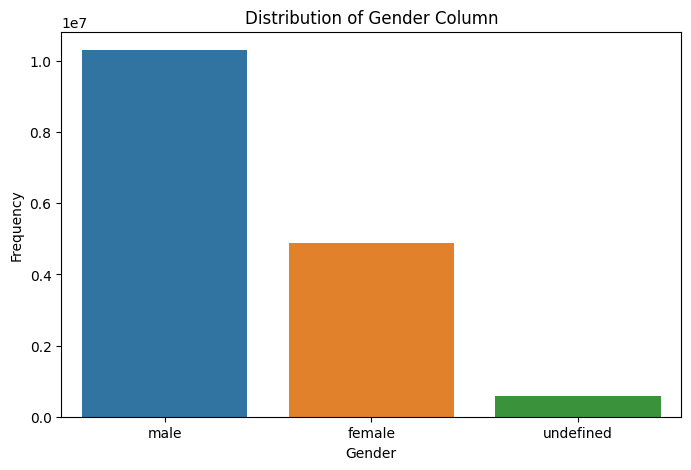

In [ ]:
# Visualize the distribution of the 'gender' column
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=gender_counts.index, y=gender_counts.values, hue=gender_counts.index)
plt.title("Distribution of Gender Column")
plt.ylabel("Frequency"); plt.xlabel("Gender")
plt.show()

**b. Handling Missing Values**

In [ ]:
# Preview of missing values
print(df.isnull().sum())

created_at                0
id                        0
lng                10481873
lat                10481873
topic                     0
sentiment                 0
stance                    0
gender                    0
temperature_avg    10481873
aggressiveness            0
dtype: int64


In [ ]:
# Removing rows with missing values
df.dropna(inplace=True)

# Verify missing values are removed
print("\nMissing values after removal:")
print(df.isnull().sum())


Missing values after removal:
created_at         0
id                 0
lng                0
lat                0
topic              0
sentiment          0
stance             0
gender             0
temperature_avg    0
aggressiveness     0
dtype: int64


**c. Removing Duplicates**

In [ ]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

**d. Outlier Detection**

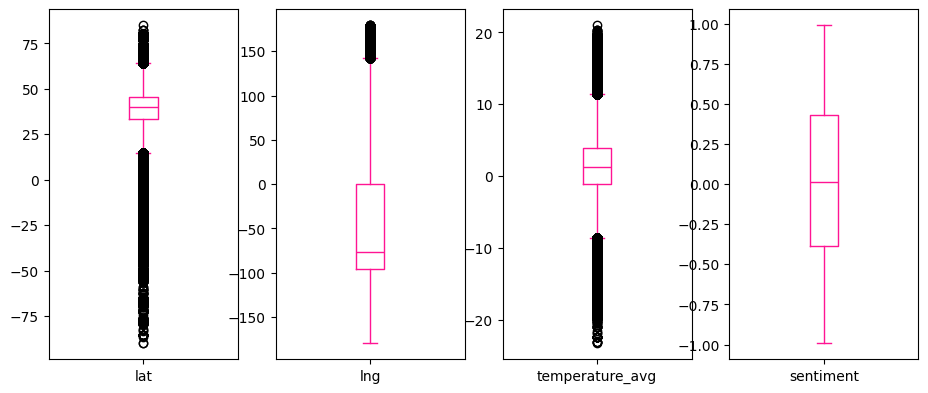

In [ ]:
# Visualize the numerical columns using a box plot
df[["lat", "lng", "temperature_avg", "sentiment"]].plot(
    kind='box', subplots=True, layout=(2,7), sharex=False,
    sharey=False, figsize=(20, 10), color='deeppink');

IQR method flags 1122 rows as outliers


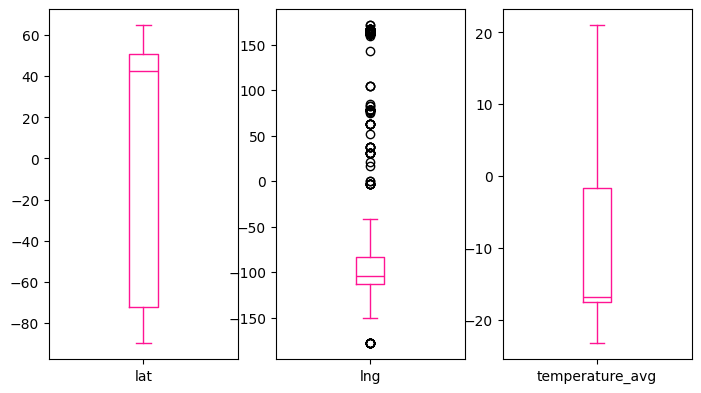

In [ ]:
num_cols = ["lat", "lng", "temperature_avg"]

# Compute Q1, Q3 and IQR for each column
Q1 = df[num_cols].quantile(0.1); Q3 = df[num_cols].quantile(0.9); IQR = Q3 - Q1

# Define fence and Flag rows outside those fences
lower_fence = Q1 - 1.5 * IQR; upper_fence = Q3 + 1.5 * IQR
iqr_outliers = ((df[num_cols] < lower_fence) | (df[num_cols] > upper_fence)).any(axis=1)
print(f"IQR method flags {iqr_outliers.sum()} rows as outliers")

outliers = df[iqr_outliers].copy()
outliers[num_cols].plot(kind='box', subplots=True, layout=(2,7),
        sharex=False,sharey=False, figsize=(20, 10), color='deeppink');

# 3. Data Wrangling

**a. Data Structuring**

Transforming raw data into a structured format suitable for analysis

In [ ]:
# Convert date string to pandas datetime
print("Previous data type:", df['created_at'].dtype)
df['created_at'] = pd.to_datetime(df['created_at'])
print("Current data type:", df['created_at'].dtype)

Previous data type: object
Current data type: datetime64[ns, UTC]


**b. Data Encoding**

(e.g., categorical to numerical encoding)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Ensure categorical fields have numeric codes
le = LabelEncoder()
df["stance_idx"] = le.fit_transform(df["stance"])
df["gender_idx"] = le.fit_transform(df["gender"])
df["agg_idx"]    = le.fit_transform(df["aggressiveness"])

# One‐hot encode 'topic'
topic_ohe = pd.get_dummies(df["topic"], prefix="topic")
df = pd.concat([df, topic_ohe], axis=1)

df[['agg_idx', 'stance_idx', 'gender_idx']].head()

,agg_idx,stance_idx,gender_idx
1,0,2,2
7,0,2,1
8,0,1,1
9,1,2,1
11,0,2,1


**c. Feature engineering**

Creating new relevant variables

In [ ]:
df["hour"]       = df["created_at"].dt.hour
df["dayofweek"]  = df["created_at"].dt.dayofweek # Monday=0 … Sunday=6
df["month"]      = df["created_at"].dt.month

# Drop the id field
df.drop('id', axis=1, inplace=True)

**d. Data Normalization and Scaling**

Data normalization and scaling for consistency

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ["lng", "lat", "temperature_avg", "sentiment", "hour", "dayofweek", "month"]
scaled_df = df.copy()
scaled_df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
scaled_df.head(2)

,created_at,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness,stance_idx,...,topic_Impact of Resource Overconsumption,topic_Importance of Human Intervantion,topic_Politics,topic_Seriousness of Gas Emissions,topic_Significance of Pollution Awareness Events,topic_Undefined / One Word Hashtags,topic_Weather Extremes,hour,dayofweek,month
1,2006-07-23 21:52:30+00:00,-0.366314,0.294688,Weather Extremes,1.267296,neutral,undefined,-0.621068,aggressive,2,...,False,False,False,False,False,False,True,1.204545,1.693207,-0.012912
7,2006-12-14 01:39:10+00:00,-1.010589,0.165723,Ideological Positions on Global Warming,-1.273596,neutral,male,0.785145,aggressive,2,...,False,False,False,False,False,False,False,-1.681265,0.125811,1.350439


# 4. Descriptive Analytics

**a. Basic Statistics**

Compute measures like mean, median, standard deviation to summarize climate parameters (e.g., temperature).

In [ ]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
lng,5307538.0,-46.391175,75.231616,-179.667010,-95.363270,-77.036370,-0.148315,179.383000
lat,5307538.0,34.080250,22.294297,-90.000000,33.150674,39.952330,45.508840,85.000000
temperature_avg,5307538.0,1.245156,3.799786,-23.289040,-1.140978,1.211522,3.867153,21.003502
sentiment,5307538.0,0.017180,0.440779,-0.992923,-0.385610,0.009963,0.430839,0.989571
hour,5307538.0,12.651945,6.930464,0.000000,7.000000,14.000000,18.000000,23.000000
dayofweek,5307538.0,2.759197,1.914003,0.000000,1.000000,3.000000,4.000000,6.000000
month,5307538.0,7.047355,3.667435,1.000000,4.000000,7.000000,10.000000,12.000000


In [ ]:
median_temp = df["temperature_avg"].median()

print(f"Global Median Temperature (°C): {median_temp:.2f}")

Global Median Temperature (°C): 1.21


In [ ]:
monthly = (df
    .groupby(df["month"])["temperature_avg"]
    .agg(["mean","median","std"])
)
print("Monthly Temperature Summary:\n", monthly)

Monthly Temperature Summary:
            mean    median       std
month                              
1      0.848614  1.164024  4.865982
2      0.731617  0.717171  4.754379
3      0.033895  0.009367  3.785681
4      1.046161  1.058952  3.803924
5      1.753774  1.657046  3.224016
6      1.246820  1.027968  2.822457
7      1.167356  0.879639  2.821820
8      1.389747  1.108211  3.010684
9      1.701668  1.487998  3.225680
10     1.698565  1.490378  3.256508
11     1.181999  0.985026  3.434059
12     1.285901  1.462431  4.488925


**b. Frequency Distribution**

Categorize climate variables (e.g., days with extreme weather events).

In [ ]:
# Compute quartiles and fences
Q1 = df["temperature_avg"].quantile(0.25)
Q3 = df["temperature_avg"].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Define bin edges and labels
#    Edges: [–∞, lower_fence, Q1, Q3, upper_fence, +∞]
bins  = [-float("inf"), lower_fence, Q1, Q3, upper_fence, float("inf")]
labels = [
    "Extreme Cold",
    "Cold",
    "Moderate",
    "Hot",
    "Extreme Hot"
]

# Apply pd.cut to categorize temperature_avg
df["temp_category"] = pd.cut(
    df["temperature_avg"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Compute frequency distribution
freq_dist = df["temp_category"].value_counts().sort_index()
print("Temperature Category Frequencies:\n", freq_dist)

Temperature Category Frequencies:
 temp_category
Extreme Cold      74115
Cold            1253741
Moderate        2688212
Hot             1268215
Extreme Hot       23255
Name: count, dtype: int64


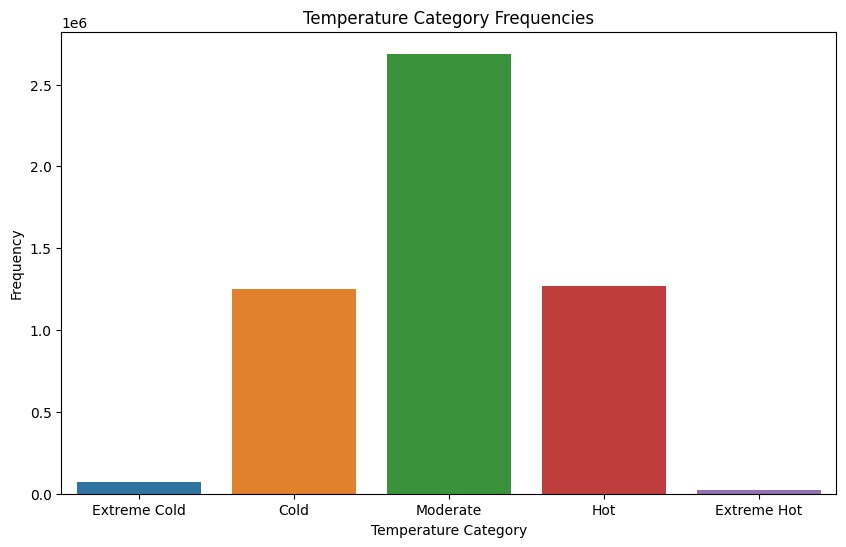

In [ ]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=freq_dist.index, y=freq_dist.values, hue=freq_dist.index)
plt.title("Temperature Category Frequencies")
plt.xlabel("Temperature Category")
plt.ylabel("Frequency")
plt.show()

**c. Visualization**

Use histograms and boxplots for data distribution insights.

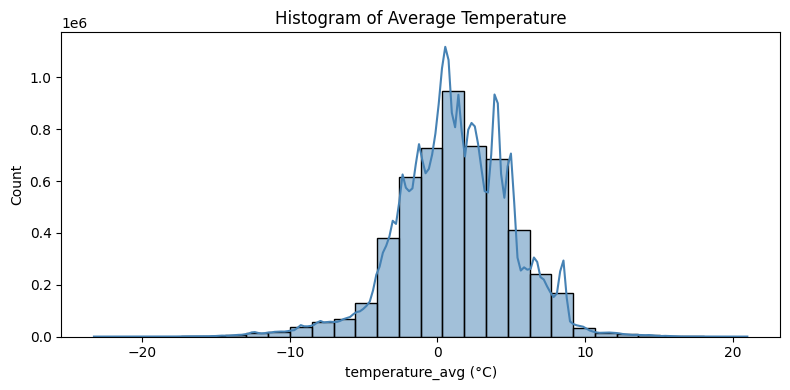

In [ ]:
# Histogram of temperature_avg
plt.figure(figsize=(8,4))
sns.histplot(df["temperature_avg"], bins=30, kde=True, color="steelblue")
plt.title("Histogram of Average Temperature")
plt.xlabel("temperature_avg (°C)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

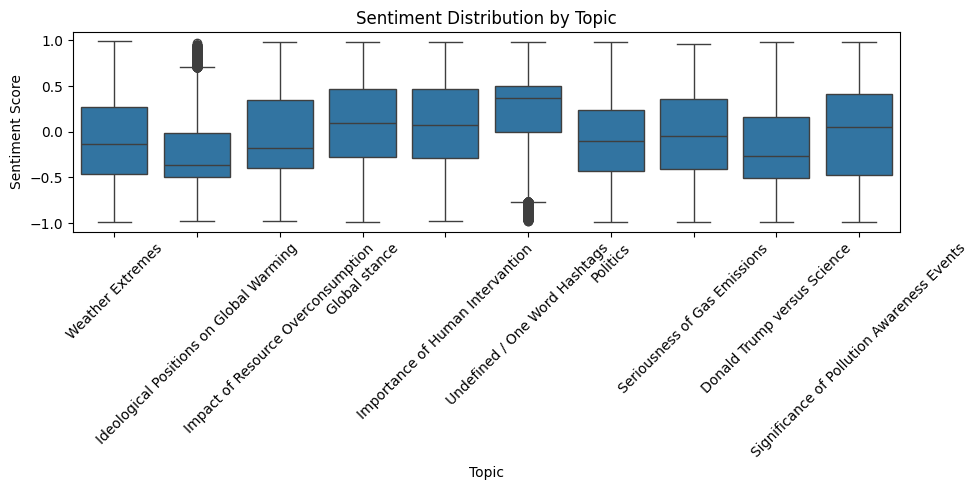

In [ ]:
# Box plot of sentiment by topic
plt.figure(figsize=(10,5)); sns.boxplot(x="topic", y="sentiment", data=df)
plt.title("Sentiment Distribution by Topic"); plt.xlabel("Topic")
plt.ylabel("Sentiment Score"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

**d. Correlation Analysis**

Identify relationships between features.

<Axes: >

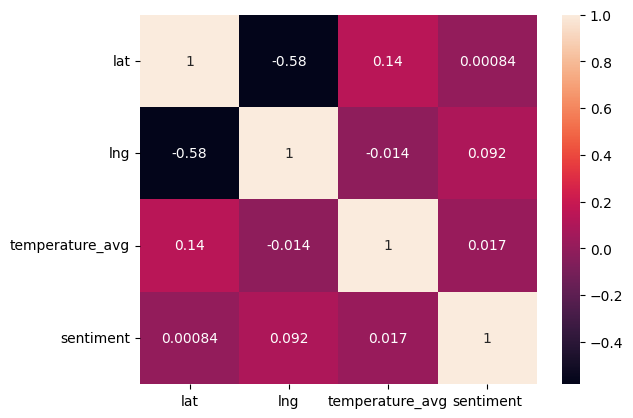

In [ ]:
# Visualize the correlation between the numerical columns
sns.heatmap(df[["lat", "lng", "temperature_avg", "sentiment"]].corr(), annot=True)

# 5. Diagnostic Analysis

**a. Identifying Risk Factors**

Assess correlations between climate variables

In [ ]:
numeric_cols = ["temperature_avg", "lat", "lng", "sentiment"]

# Pearson correlation matrix
pearson_corr = df[numeric_cols].corr(method="pearson")
print("Pearson Correlation:\n", pearson_corr)

# Spearman correlation matrix
spearman_corr = df[numeric_cols].corr(method="spearman")
print("\nSpearman Correlation:\n", spearman_corr)

Pearson Correlation:
                  temperature_avg       lat       lng  sentiment
temperature_avg         1.000000  0.139704 -0.014246   0.017387
lat                     0.139704  1.000000 -0.582249   0.000840
lng                    -0.014246 -0.582249  1.000000   0.091934
sentiment               0.017387  0.000840  0.091934   1.000000

Spearman Correlation:
                  temperature_avg       lat       lng  sentiment
temperature_avg         1.000000  0.176059  0.054039   0.009410
lat                     0.176059  1.000000 -0.026271   0.036126
lng                     0.054039 -0.026271  1.000000   0.107090
sentiment               0.009410  0.036126  0.107090   1.000000


**b. Anomaly Detection**

Detect sudden spikes in temperature or extreme weather events.

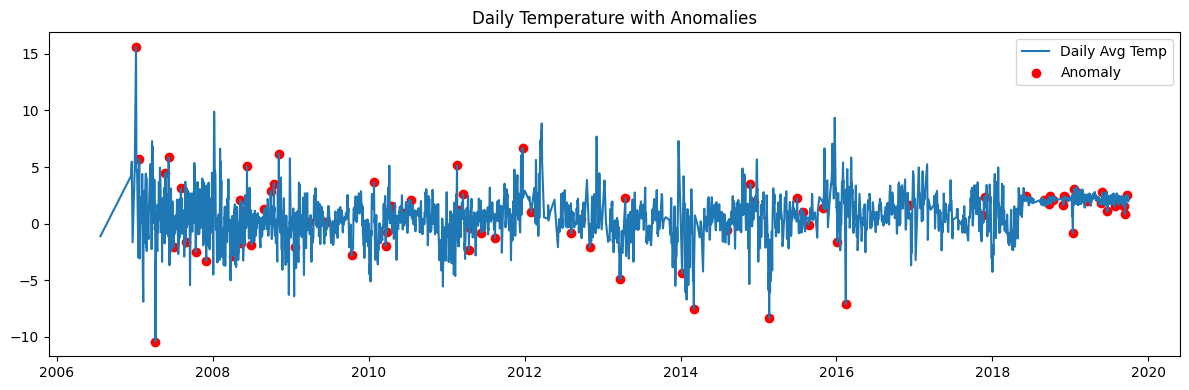

In [ ]:
# Aggregate to daily average temperature
df["date"] = df["created_at"].dt.date
daily = df.groupby("date")["temperature_avg"].mean().rename("avg_temp").to_frame()

# Sort by date
daily = daily.sort_index()

# Define rolling window (e.g., 7 days)
window = 7

# Compute rolling mean & std (for z‐score)
daily["roll_mean"] = daily["avg_temp"].rolling(window, center=True, min_periods=3).mean()
daily["roll_std"]  = daily["avg_temp"].rolling(window, center=True, min_periods=3).std()

# Compute z‐score and flag anomalies (>3σ)
daily["z_score"]    = (daily["avg_temp"] - daily["roll_mean"]) / daily["roll_std"]
daily["anomaly_z"]  = daily["z_score"].abs() > 3

# Compute rolling IQR and fences
Q1 = daily["avg_temp"].rolling(window, center=True, min_periods=3).quantile(0.25)
Q3 = daily["avg_temp"].rolling(window, center=True, min_periods=3).quantile(0.75)
IQR = Q3 - Q1
daily["lower_fence"] = Q1 - 1.5 * IQR
daily["upper_fence"] = Q3 + 1.5 * IQR

# Flag IQR outliers
daily["anomaly_iqr"] = (daily["avg_temp"] < daily["lower_fence"]) | (daily["avg_temp"] > daily["upper_fence"])

# Combine flags
daily["is_anomaly"] = daily["anomaly_z"] | daily["anomaly_iqr"]
anoms = daily[daily["is_anomaly"]]

# Plot daily temps and anomalies
plt.figure(figsize=(12,4))
plt.plot(daily.index, daily["avg_temp"], label="Daily Avg Temp")
plt.scatter(anoms.index, anoms["avg_temp"], color="red", label="Anomaly")
plt.legend(); plt.title("Daily Temperature with Anomalies")
plt.tight_layout(); plt.show()

**c. Trend Analysis**

Examine long-term shifts in climate patterns.

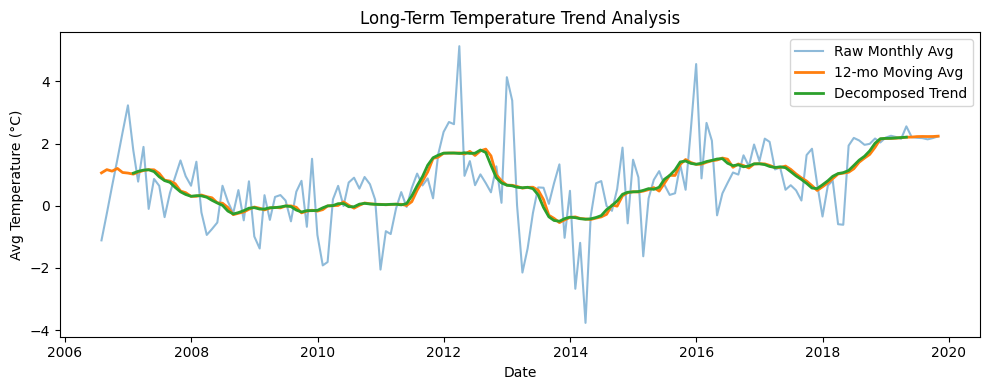

In [ ]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


# Aggregate to MONTHLY average temperature
trend_df = df.copy()
trend_df.set_index("created_at", inplace=True)
monthly = trend_df["temperature_avg"].resample("ME").mean().rename("temp_monthly")

# Fill missing values using linear interpolation
monthly = monthly.interpolate(method='linear')

# Moving‐average smoothing (12‐month window)
monthly_ma = monthly.rolling(window=12, center=True, min_periods=6).mean()

# Seasonal‐Trend Decomposition (STL)
decomp = seasonal_decompose(monthly, model="additive", period=12)
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

# Plot everything
plt.figure(figsize=(10, 4))
plt.plot(monthly.index, monthly,       label="Raw Monthly Avg",    alpha=0.5)
plt.plot(monthly.index, monthly_ma,    label="12-mo Moving Avg",    linewidth=2)
plt.plot(trend.index,    trend,        label="Decomposed Trend",    linewidth=2)
plt.title("Long-Term Temperature Trend Analysis")
plt.xlabel("Date"); plt.ylabel("Avg Temperature (°C)")
plt.legend(); plt.tight_layout(); plt.show()

**d. Word Analysis**

Investigate words that were most related to climate data by analysing tweet structure, sentiment, and topics.

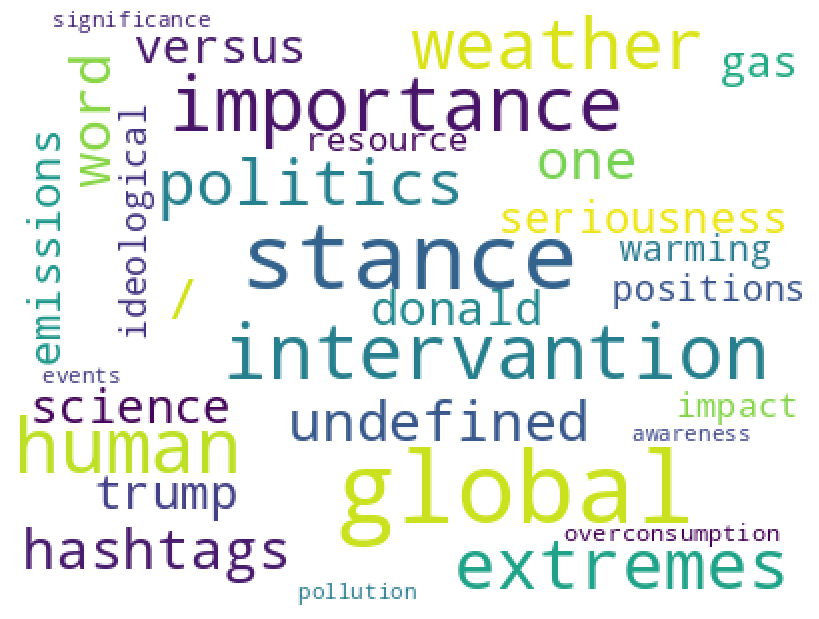

In [ ]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

word_list = [word.lower() for val in df['topic'] for word in val.split()]
word_dict = {key: val for key, val in Counter(word_list).items() if key not in STOPWORDS}

wordcloud = WordCloud(width=400, height=300,
        background_color='white', max_words=50,
        min_font_size=10, max_font_size=50).generate_from_frequencies(word_dict)

# Plot the word cloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud); plt.axis("off")
plt.tight_layout(pad=0); plt.show()

In [ ]:
wordcloud.words_

{'global': 1.0,
 'stance': 0.892277009297215,
 'importance': 0.5426556028242449,
 'human': 0.5426556028242449,
 'intervantion': 0.5426556028242449,
 'weather': 0.4643598624361156,
 'extremes': 0.4643598624361156,
 'politics': 0.3776143269478913,
 'undefined': 0.2799743516688803,
 '/': 0.2799743516688803,
 'one': 0.2799743516688803,
 'word': 0.2799743516688803,
 'hashtags': 0.2799743516688803,
 'donald': 0.20363518116421703,
 'trump': 0.20363518116421703,
 'versus': 0.20363518116421703,
 'science': 0.20363518116421703,
 'seriousness': 0.17773427133176703,
 'gas': 0.17773427133176703,
 'emissions': 0.17773427133176703,
 'ideological': 0.10772299070278502,
 'positions': 0.10772299070278502,
 'warming': 0.10772299070278502,
 'impact': 0.10066298861626521,
 'resource': 0.10066298861626521,
 'overconsumption': 0.10066298861626521,
 'significance': 0.09145789775198845,
 'pollution': 0.09145789775198845,
 'awareness': 0.09145789775198845,
 'events': 0.09145789775198845}

# 6. Predictive Analytics

**a. Regression Model**



In [ ]:
from sklearn.model_selection import train_test_split

# Numerical feature for modeling
features = (
    ["stance_idx", "gender_idx", "agg_idx", 'lat', 'lng', 'sentiment']
    + list(topic_ohe.columns)
)
X = scaled_df[features]
y = scaled_df["temperature_avg"]

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Model Fitting
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test) # Forecast

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f} °C")

Test MSE: 0.970 °C


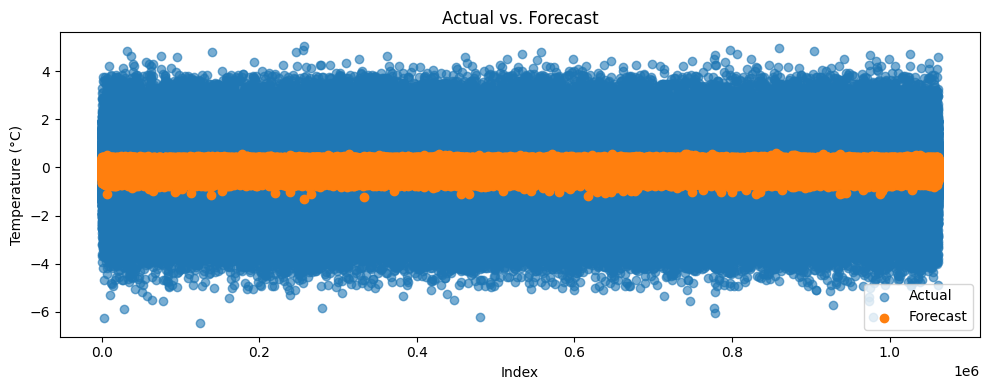

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Plot actual vs. forecast
plt.figure(figsize=(10,4))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label="Forecast", marker="o")
plt.title("Actual vs. Forecast")
plt.xlabel("Index"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.tight_layout(); plt.show()

**b. Classification Model**


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

features = (
    ["temperature_avg", "gender_idx", "agg_idx", 'lat', 'lng', 'sentiment']
    + list(topic_ohe.columns)
)
X = scaled_df[features]
y = scaled_df["stance_idx"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logisic_reg = LogisticRegression(random_state=42)
logisic_reg.fit(X_train, y_train)
y_pred = logisic_reg.predict(X_test) # Make predictions

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("----"*10)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.74
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.85    789575
           1       0.36      0.00      0.01     72941
           2       0.51      0.01      0.02    198992

    accuracy                           0.74   1061508
   macro avg       0.54      0.34      0.29   1061508
weighted avg       0.67      0.74      0.64   1061508



**c. Clustering**

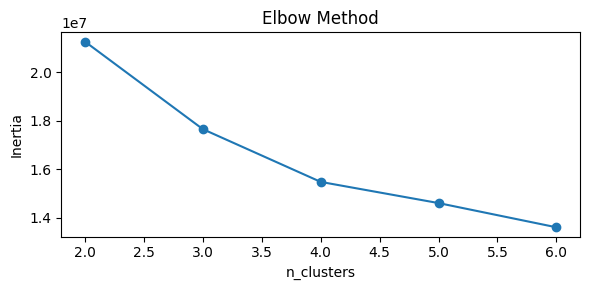

In [ ]:
from sklearn.cluster import KMeans

# We cluster on the following columns
cols = [
    'temperature_avg', 'gender_idx', 'agg_idx', 'lat', 'lng', 'sentiment', 'stance_idx'
    ]
df_clust = df[cols]

# Select K via Elbow
inertia = []
K_range = range(2, 7)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)

# Plot elbow
plt.figure(figsize=(6,3))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("n_clusters")
plt.ylabel("Inertia")
plt.tight_layout(); plt.show()

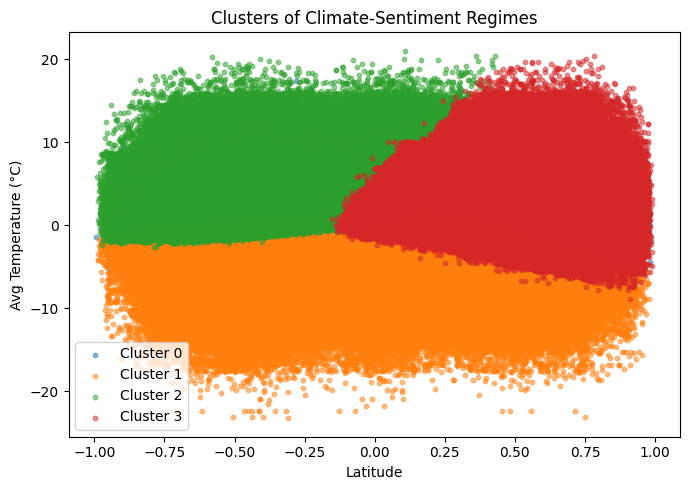

In [ ]:
# Fit final K-means
K_final = 4
km_final = KMeans(n_clusters=K_final, random_state=42)
df_clust["cluster"] = km_final.fit_predict(X)

# Visualize (Sentiment vs. temperature colored by cluster)
plt.figure(figsize=(7, 5))
for c in range(K_final):
    subset = df_clust[df_clust["cluster"]==c]
    plt.scatter(subset["sentiment"], subset["temperature_avg"],
                label=f"Cluster {c}", alpha=0.5, s=10)

plt.xlabel("Latitude")
plt.ylabel("Avg Temperature (°C)")
plt.title("Clusters of Climate-Sentiment Regimes")
plt.legend(); plt.tight_layout(); plt.show()

**d. Time Series Analysis**

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6thtf1y/bamqo53t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6thtf1y/rfvmd42f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99060', 'data', 'file=/tmp/tmpw6thtf1y/bamqo53t.json', 'init=/tmp/tmpw6thtf1y/rfvmd42f.json', 'output', 'file=/tmp/tmpw6thtf1y/prophet_model5o73i2e1/prophet_model-20250526171035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


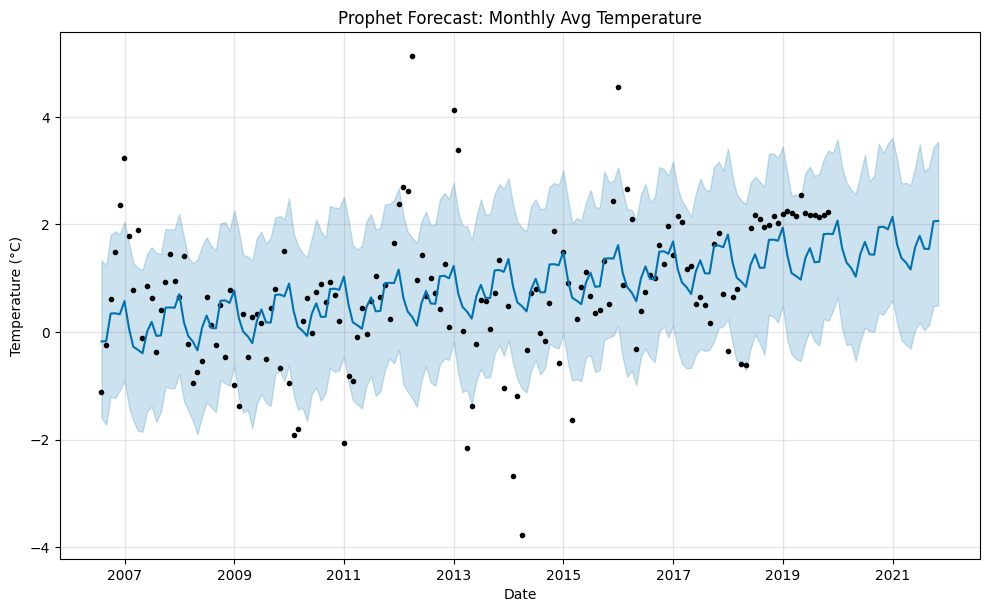

In [ ]:
from prophet import Prophet

monthly = monthly.reset_index()
monthly.rename(columns={"created_at":"ds", "temp_monthly":"y"}, inplace=True)
# Ensure the 'ds' column is timezone-naive
monthly['ds'] = monthly['ds'].dt.tz_localize(None)

# Fit Prophet model
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(monthly)

# Create a DataFrame for future 24 months
future = m.make_future_dataframe(periods=24, freq="M", )
forecast = m.predict(future)

# Plot forecast
fig1 = m.plot(forecast)
plt.title("Prophet Forecast: Monthly Avg Temperature")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.show()